### Related works Architecture:

- Original Transformer

- BERT

- BART

- T5

- DeBERTa

- GPT-NeoX

- PaLM

In [20]:
from underthesea import word_tokenize
import re
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Just to keep in mind the wseg will not be used here to match with the PhoBERT tokenization algorithm

In [2]:
word_tokenize('Ban hành Nghị định sửa đổi Luật Đất đai')

['Ban hành', 'Nghị định', 'sửa đổi', 'Luật', 'Đất đai']

In [4]:
tokenizer.tokenize('Ban hành Nghị định sửa đổi Luật Đất đai')

['Ban', 'hành', 'Nghị', 'định', 'sửa', 'đổi', 'Luật', 'Đất', 'đai']

### Document type Mask matrix

To be used in the Self-attention layer of Encoder, note that although word_tokenize can be applied for Wseg, we have to follow the PhoBERT tokenization formula to maintain the consistency and thus making the mask 1 in both subwords of a Wseg

Having a tokenized sentence (by Wseg)

S = [$w_1, w_2,....w_N$]

and a lexicon (defined list of known legal document types)

Create a mask matrix $M_L \in R^{N x N}$

$m_ij$ = 1 if S[i:j] matches lexicon phrase

= 0 otherwise

Also rescale so that non-legal tokens can still attend to other tokens

In [42]:
def build_legal_mask(text):
    tokens = tokenizer.tokenize(text.lower())
    n = len(tokens)
    M = torch.zeros((n, n), dtype=torch.int)

    single = {'luật', 'pháp', 'điều', 'chương', 'khoản', 'mục'}
    anchors = {"nghị", "thông", "quyết", "hiến", "luật", "pháp"}
    followers = {"định", "quyết", "tư", "pháp", "lệnh"}

    for i, tok in enumerate(tokens):
        # mark single-word types like "luật", "pháp"
        if tok in single:
            M[i, i] = 1
        # mark legal multiword combos (anchor + follower)
        if tok in anchors and i + 1 < n:
            if tokens[i + 1] in followers:
                M[i, i] = 1
                M[i + 1, i + 1] = 1
                M[i, i + 1] = 1
                M[i + 1, i] = 1
    
    M = 0.1 + 0.9 * M #rescale so that non-legal token can still attend

    return tokens, M

In [37]:
tokens, legal = build_legal_mask('Ban hành Nghị định 23Bi/2312/NĐ-cp sửa đổi bổ sung Luật đất đai')

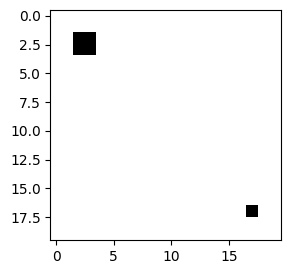

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.imshow(legal, cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show()

### Dual-encoding layers

#### PhoBERT General

In [7]:
class PhoBertEmbedding:
    def __init__(self, model_name="vinai/phobert-base", device=None, freeze=False):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

    def encode(self, texts):
        toks = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        input_ids = toks["input_ids"].to(self.device)
        attention_mask = toks["attention_mask"].to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        # last_hidden_state: (batch, seq_len, hidden)
        return outputs.last_hidden_state, attention_mask, toks

In [8]:
text = 'Ban hành Nghị định sửa đổi Luật Đất đai'

phobert = PhoBertEmbedding(freeze=True)
embeddings, attention_mask, toks = phobert.encode([text])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#### Transformer Encoder

##### Positional Encoding

Modern Transformer-based models replace the traditional PE technique with using Relative Position. Instead of calculating the actual sinusoidal position of the token, the model encode the distance between Q-K tokens, which brings better information about how words interact with each other in a sentence. 

For a sequence of Length L: $$rel_{ij} = j - i$$

we get a matrix of shape (L,L) showing the relative distance of each token with one other

For T5-style Relative Position Bias, this embedding of relative distances gives a scalar bias per head per (i,j) and for each attention head h, we get a bias matrix $B^{(h)} \in R^{L x L}$

This bias is added directly to attention logits before the softmax:

$$Attention^{(h)} = softmax(\frac{QK^T}{\sqrt{d_k}} + B^{(h)})$$

and also be combined with the Lexicon masking 

$$Attention^{(h)} = softmax(M_D * (\frac{QK^T}{\sqrt{d_k}} + B^{(h)}))$$

In [ ]:
## Learned absolute positions

class RelativePositionBias(nn.Module):
    """
    biases that are added to attention logits.
    """
    def __init__(self, max_distance, n_heads):
        super().__init__()
        self.max_distance = max_distance
        self.n_heads = n_heads
        # relative distances range from -max_distance..+max_distance -> 2*max_distance+1 buckets for exmple -8->8 to 0->16
        self.rel_emb = nn.Embedding(2 * max_distance + 1, n_heads)

    def forward(self, seq_len, device=None):
        device = device or next(self.rel_emb.parameters()).device
        # compute matrix of relative distances j - i
        idxs = torch.arange(seq_len, device=device)
        rel = idxs.unsqueeze(0) - idxs.unsqueeze(1)  # (seq, seq) with relative distances
        clipped = rel.clamp(-self.max_distance, self.max_distance) + self.max_distance #clip the values to positive range
        biases = self.rel_emb(clipped).permute(2, 0, 1)  # (n_heads, seq, seq) embedding for trainable
        return biases 

In [15]:
## Traditional sinusoidal positions

import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, dim: int, max_len: int = 5000):
        super().__init__()
        self.dim = dim

        # a long enough matrix of position encodings
        position = torch.arange(max_len).unsqueeze(1) #(max_len, 1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))

        #sine/cosine positional encodings
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, dim)

        # Register as buffer (not a parameter, not updated by optimizer)
        self.register_buffer("pe", pe)

    def forward(self, seq_len: int, device=None):
        """
        Returns positional encodings for a sequence of length seq_len.
        Output shape: (1, seq_len, dim)
        """
        device = device or self.pe.device
        return self.pe[:, :seq_len].to(device)

##### Multi-head Self-Attention layer

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1, pre_ln=True):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.d_k = dim // n_heads
        self.pre_ln = pre_ln

        #Initialize Query, Key, Value and Output projection
        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.W_o = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pos_bias=None, lex_mask=None, multiplicative=False):
        residual = x  # Save for skip connection

        # Pre-LN
        if self.pre_ln:
            x = self.norm(x)

        B, N, _ = x.size()

        Q = self.W_q(x).view(B, N, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, N, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, N, self.n_heads, self.d_k).transpose(1, 2)

        # attention logits
        attn_logits = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        # Add relative positional bias
        if pos_bias is not None:
            attn_logits = attn_logits + pos_bias.unsqueeze(0)

        # add lexicon masking
        if lex_mask is not None:
            lex_mask = lex_mask.unsqueeze(0).unsqueeze(1)  # (1,1,N,N)
            if multiplicative:
                attn_logits = attn_logits * lex_mask
            else:
                attn_logits = attn_logits + lex_mask

        attn = F.softmax(attn_logits, dim=-1)
        attn = self.dropout(attn)

        # ---- Weighted sum ----
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, N, self.dim) #concat heads together
        out = self.W_o(out) #Final linear layer for combining heads
        out = self.dropout(out)

        out = out + residual #add skip connection
        
        if not self.pre_ln:
            out = self.norm(out)

        return out, attn

##### Feed-Forward NN with Residual Connection and LayerNorm

Note that modern models (T5, DeBERTa, GPT) apply Pre-LN which is LayerNorm before running the first linear combination and also apply 2 dropout after each linear combination to help regularize the parameters to avoid overfitting, useful in large deep models

Also modern models utilize the GeLU activation instead of traditional ReLU in the MLP

GeLU: Gaussian Error Linear Unit has the mathematical definition: 

$$GeLU(x) = x.\Theta(x)$$

where $\Theta(x)$ is the cumulative distribution function (CDF) of a standard normal distribution 

$$GeLU(x) = 0.5x(1 + erf(\frac{x}{\sqrt{2}}))$$

Instead of making hard decision whether x > 0 in ReLU, GeLU makes a probabilistic decision based on how large x is, this makes the gradient smoother than ReLU and allows smoother transition while partially keeping small negative values

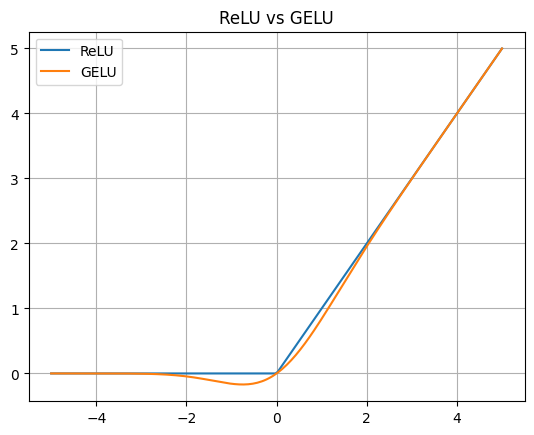

In [ ]:
x = torch.linspace(-5, 5, 200)
relu = F.relu(x)
gelu = F.gelu(x)

plt.plot(x, relu, label='ReLU')
plt.plot(x, gelu, label='GELU')
plt.legend()
plt.grid(True)
plt.title("ReLU vs GELU")
plt.show()


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        hidden_dim = hidden_dim or 4 * dim  # default expansion that hidden dim is 4 x model_dim
        self.norm = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-LN + MLP + Residual
        residual = x
        x = self.norm(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return residual + x #Skip connection

#### Encoder Layer

In [32]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1, ff_hidden_dim=None):
        super().__init__()
        self.attn = MultiHeadSelfAttention(dim, n_heads, dropout=dropout, pre_ln=True)
        self.ff = FeedForward(dim, hidden_dim=ff_hidden_dim, dropout=dropout)

    def forward(self, x, rel_pos_bias=None, lex_mask=None):
        #Multi-head self-attention
        x, _ = self.attn(x, pos_bias=rel_pos_bias, lex_mask=lex_mask)
        #FFN
        x = self.ff(x)
        return x

In [ ]:
class CombinedEmbedding(nn.Module):
    def __init__(self, phobert, transformer_encoder, alpha=0.5):
        super().__init__()
        self.phobert = phobert
        self.encoder = transformer_encoder
        self.alpha = nn.Parameter(torch.tensor(alpha))  # learnable weighting

    def forward(self, texts, rel_pos_bias=None, lex_mask=None):
        # PhoBERT
        pho_hidden, attn_mask, toks = self.phobert.encode(texts)  # (batch, seq_len, hidden_dim)

        # Transformer encoder 
        trans_hidden = self.encoder(pho_hidden, rel_pos_bias=rel_pos_bias, lex_mask=lex_mask)

        # linear combination between PhoBERT and encoder
        alpha = torch.clamp(self.alpha, 0.0, 1.0) #for interpolation and alpha can be trained for optimization
        combined = alpha * pho_hidden + (1 - alpha) * trans_hidden

        return combined, attn_mask, toks

In [34]:
phobert = PhoBertEmbedding(freeze=True)
encoder = TransformerEncoderLayer(dim=768, n_heads=12, ff_hidden_dim=2048, dropout=0.1)
combined_model = CombinedEmbedding(phobert, encoder, alpha=0.5)

texts = [
    "Doanh nghiệp có thu nhập chịu thuế quy định tại Điều 3 của Luật này phải nộp thuế.",
    "Quyết định Căn cứ Nghị định số 55/2025/NĐ-CP ngày 02 tháng 3 năm 2025 của Chính phủ quy định chức năng, nhiệm vụ, quyền hạn và cơ cấu tổ chức của Bộ Khoa học và Công nghệ"
]

combined_output, attn_mask, toks = combined_model(texts)
print(combined_output.shape)  # (batch, seq_len, 768)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([2, 46, 768])


### Decoder